# 3.2 & 3.3 - Linear Regression with Continuous Predictors and Multiple Predictors

#### Disclaimer:

IQ is, at best, a misleading measure of a poorly-defined social construct
and, at worst, a nefarious tool of social control and scientific racism at worst.
I'm merely using this data because it is freely available
and I can work off of pre-existing examples.

In [1]:
import pystan

In [2]:
import statsmodels.formula.api as smf

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(font_scale=3)

In [4]:
%matplotlib inline

Data can be downloaded from [here](http://www.stat.columbia.edu/~gelman/arm/software/).

We now move on to slightly more complex models: univariate and bivariate linear regression with a Gaussian noise model.

Note that none of these changes affect the underlying graphical model for Bayesian linear regression;
we are just redefining $x$ and the edge from $x$ to $y$.

## Visualizing the Data

We first load the data.

In [5]:
kid_path = "../ARM_Data/child.iq/kidiq.dta"
kid_df =  pd.io.stata.read_stata(kid_path)
kid_df.head()

,kid_score,mom_hs,mom_iq,mom_work,mom_age
0,65,1.0,121.117529,4,27
1,98,1.0,89.361882,4,25
2,85,1.0,115.443165,4,27
3,83,1.0,99.449639,3,25
4,115,1.0,92.745710,4,27


And then we pick an appropriate visualization.

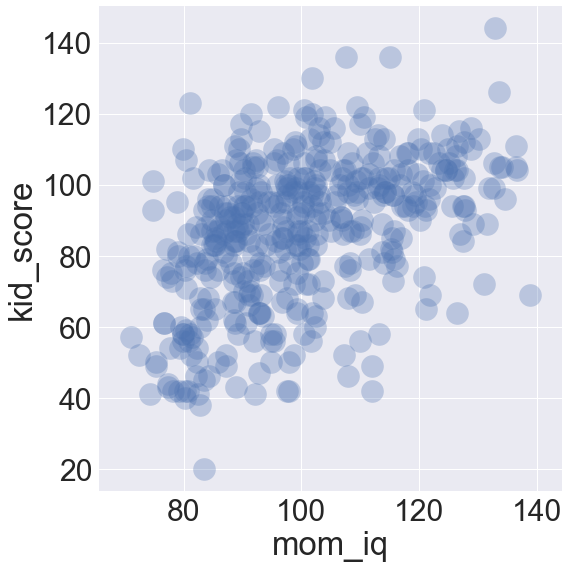

In [6]:
sns.lmplot('mom_iq', 'kid_score', data=kid_df, fit_reg=False, size=8,
          scatter_kws={"alpha":0.3, "s":512,});

In [7]:
def train_test_split(df, train_fraction=0.8):
    total_N = len(kid_df)
    test_fraction = 1-train_fraction
    
    train_set_size = int(total_N*train_fraction); test_set_size = total_N - train_set_size

    train_set_indices = np.random.choice(total_N, size=train_set_size, replace=False)
    
    train_df = df.iloc[train_set_indices]
    test_df = df.iloc[[index for index in range(total_N) if index not in train_set_indices]]
    
    return train_df, test_df

In [8]:
train_df, test_df = train_test_split(kid_df)

## Single, Continuous Regressor

### Least-Squares

In [9]:
mom_iq_mod = smf.ols("kid_score ~ mom_iq", data=train_df)

mom_iq_results = mom_iq_mod.fit()

print(mom_iq_results.summary())

                            OLS Regression Results                            
Dep. Variable:              kid_score   R-squared:                       0.215
Model:                            OLS   Adj. R-squared:                  0.213
Method:                 Least Squares   F-statistic:                     94.43
Date:                Fri, 23 Feb 2018   Prob (F-statistic):           6.87e-20
Time:                        22:53:37   Log-Likelihood:                -1501.2
No. Observations:                 347   AIC:                             3006.
Df Residuals:                     345   BIC:                             3014.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     22.9878      6.603      3.481      0.0

This model is a substantially better predictor of child IQ than our model just based on educational attainment.

For the training data, we get a somewhat respectable variance explained:

In [10]:
1-mom_iq_results.mse_resid/mom_iq_results.mse_total

0.21262168549697702

Which remains the case for the test data.

In [11]:
mom_iq_predictions = mom_iq_results.predict(test_df.mom_iq)

In [12]:
errors = test_df.kid_score-mom_iq_predictions
test_mse = np.var(errors, ddof=1)
test_mse_total = test_df.kid_score.var()

1-test_mse/test_mse_total

0.14338787376808226

### Bayesian Regression

The code for the model is the same.
3 cheers for abstraction barriers!

In [13]:
data_code = """data {
  int N_train; //the number of training set examples
  int N_test; //the number of test set examples
  int K; //the number of columns in the model matrix
  real y[N_train]; //the response
  matrix[N_train,K] train_X; //the design matrix for the training set
  matrix[N_test,K] test_X; //the design matrix for the test set
}"""

parameters_code = """parameters {
  vector[K] beta; //the regression parameters
  real<lower=0> sigma; //the standard deviation
}"""

prediction_code = """transformed parameters {
  vector[N_train] linear_prediction;
  linear_prediction <- train_X*beta;
}"""

model_code = """model {  
  y ~ normal(linear_prediction,sigma); // conditional of the target
}"""

test_prediction_code = """generated quantities {
  vector[N_test] y_pred;
  y_pred <- test_X*beta; //the y values predicted by the model
}"""

We then combine this together by string concatenation
to produce the code for the whole model.

In [14]:
mom_iq_model_code = data_code+parameters_code+prediction_code+model_code+test_prediction_code

In [15]:
mom_iq_stanmodel = pystan.StanModel(model_code=mom_iq_model_code, model_name='mom_iq')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL mom_iq_45389953cd287b4929d0e5dff33a664d NOW.


We now construct the design matrices.

In [16]:
def make_affine_term(data):
    return np.ones(shape=data.shape[0])

def make_design_matrix(df, var, add_interaction=False):
    variables = np.atleast_2d(df[var])
    if variables.shape[0] == 1:
        variables = variables.T
    if add_interaction:
        variables = add_interaction_term(variables, cols=[0,1])
    return np.hstack([variables, np.expand_dims(make_affine_term(df[var]),axis=1)])

def add_interaction_term(design_matrix, cols=[0,1]):
    interaction_column = np.expand_dims(np.multiply(design_matrix[:,cols[0]], design_matrix[:,cols[1]]),1)
    return np.hstack([design_matrix, interaction_column])


In [17]:
mom_iq_design_matrix = make_design_matrix(train_df, "mom_iq")
mom_iq_test_design_matrix = make_design_matrix(test_df, "mom_iq")

We organize the model parameters into a dictionary to be fed into the model.

In [18]:
mom_iq_data = {'N_train': len(train_df),
           'N_test': len(test_df),
               'K': 2,
               'y': train_df.kid_score,
              'train_X': mom_iq_design_matrix,
          'test_X': mom_iq_test_design_matrix}

In [19]:
mom_iq_samples = mom_iq_stanmodel.sampling(data=mom_iq_data, iter=1000, chains=4)

/Users/charlesfrye/anaconda3/envs/graph_models/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


In [20]:
train_predictions = mom_iq_samples.extract("linear_prediction")["linear_prediction"]
test_predictions = mom_iq_samples.extract("y_pred")["y_pred"]

In [21]:
def compute_errors(predictions, observed_values):
    errors = predictions - np.asarray(observed_values)
    return errors

In [22]:
train_errors = compute_errors(train_predictions, train_df.kid_score)
test_errors = compute_errors(test_predictions, test_df.kid_score)

In [23]:
np.sqrt(np.mean(np.square(train_errors)))

18.362640996264684

In [24]:
mom_iq_samples_mse = np.var(test_errors, ddof=1)

In [25]:
1-mom_iq_samples_mse/test_df.kid_score.var()

0.1474229498751155

In [26]:
betas = mom_iq_samples.extract('beta')['beta']

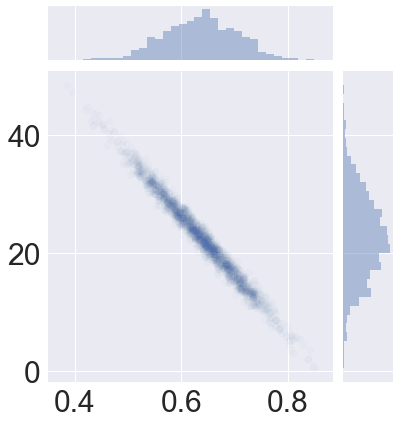

In [27]:
sns.jointplot(betas[:,0], betas[:,1], stat_func=None, joint_kws={"alpha":0.025});

## Two Independent Predictors

### Least Squares

In [28]:
paired_mod = smf.ols("kid_score ~ mom_iq + mom_hs", data=train_df)

paired_mod = paired_mod.fit()

print(paired_mod.summary())

                            OLS Regression Results                            
Dep. Variable:              kid_score   R-squared:                       0.224
Model:                            OLS   Adj. R-squared:                  0.219
Method:                 Least Squares   F-statistic:                     49.55
Date:                Fri, 23 Feb 2018   Prob (F-statistic):           1.23e-19
Time:                        22:54:35   Log-Likelihood:                -1499.2
No. Observations:                 347   AIC:                             3004.
Df Residuals:                     344   BIC:                             3016.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     22.4011      6.583      3.403      0.0

### Bayesian Regression

In [29]:
paired_model_code = mom_iq_model_code

In [30]:
paired_stanmodel = pystan.StanModel(model_code=mom_iq_model_code, model_name="paired")

INFO:pystan:COMPILING THE C++ CODE FOR MODEL paired_45389953cd287b4929d0e5dff33a664d NOW.


In [31]:
paired_design_matrix = make_design_matrix(train_df, ["mom_iq","mom_hs"])
paired_test_design_matrix = make_design_matrix(test_df, ["mom_iq","mom_hs"])

In [32]:
paired_data = {'N_train': len(train_df),
           'N_test': len(test_df),
               'K': 3,
               'y': train_df.kid_score,
              'train_X': paired_design_matrix,
          'test_X': paired_test_design_matrix}

In [33]:
paired_samples = paired_stanmodel.sampling(data=paired_data, iter=1000, chains=4)

/Users/charlesfrye/anaconda3/envs/graph_models/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


In [34]:
betas = paired_samples.extract('beta')['beta']

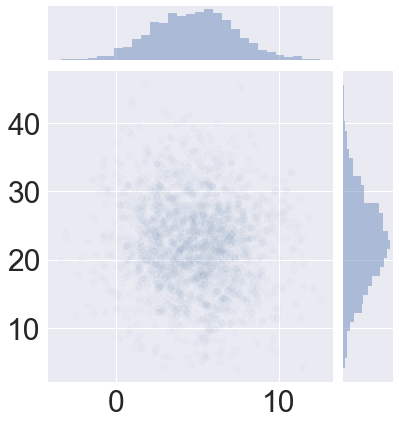

In [35]:
sns.jointplot(betas[:,1], betas[:,2], stat_func=None, joint_kws={"alpha":0.025});

In [36]:
train_predictions = paired_samples.extract("linear_prediction")["linear_prediction"]
test_predictions = paired_samples.extract("y_pred")["y_pred"]

In [37]:
train_errors = compute_errors(train_predictions, train_df.kid_score)

train_mse = np.mean(np.square(train_errors))

In [38]:
test_errors = compute_errors(test_predictions, test_df.kid_score)

test_mse = np.mean(np.square(test_errors))

In [39]:
1-test_mse/test_df.kid_score.var()

0.1578611366128937

## Joint Model

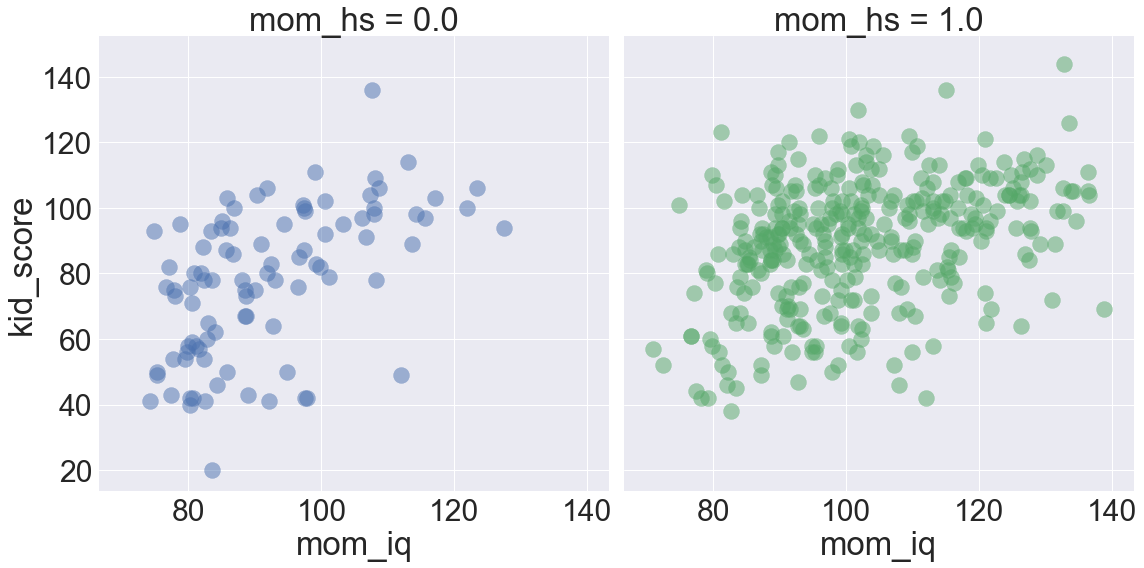

In [40]:
g = sns.FacetGrid(data=kid_df, col='mom_hs', hue='mom_hs', size=8, aspect=1);
g = g.map(plt.scatter, 'mom_iq', 'kid_score',
          alpha=0.5, s=256,
         )

### Least Squares

In [41]:
joint_model = smf.ols('kid_score ~ mom_iq*mom_hs', data=kid_df);

In [42]:
joint_model_results = joint_model.fit()

In [43]:
print(joint_model_results.summary())

                            OLS Regression Results                            
Dep. Variable:              kid_score   R-squared:                       0.230
Model:                            OLS   Adj. R-squared:                  0.225
Method:                 Least Squares   F-statistic:                     42.84
Date:                Fri, 23 Feb 2018   Prob (F-statistic):           3.07e-24
Time:                        22:55:34   Log-Likelihood:                -1867.5
No. Observations:                 434   AIC:                             3743.
Df Residuals:                     430   BIC:                             3759.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept       -11.4820     13.758     -0.835

In [44]:
joint_model_predicted_kid_scores = joint_model_results.get_prediction(test_df).predicted_mean

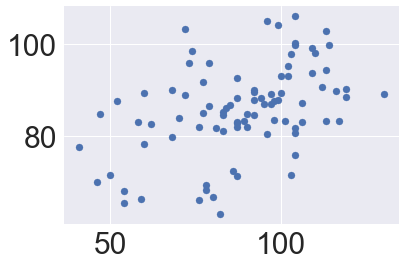

In [45]:
plt.scatter(test_df.kid_score,joint_model_predicted_kid_scores);

In [46]:
joint_errors = compute_errors(joint_model_predicted_kid_scores,test_df.kid_score)
joint_mse = np.mean(np.square(joint_errors))
joint_rmse = np.sqrt(joint_mse)
joint_rmse

17.365060440928936

In [47]:
joint_mse/test_df.kid_score.var()

0.8085988143711856

In [48]:
joint_model_code = mom_iq_model_code

In [49]:
joint_stanmodel = pystan.StanModel(model_code=joint_model_code, model_name='joint')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL joint_45389953cd287b4929d0e5dff33a664d NOW.


In [50]:
joint_design_matrix = make_design_matrix(train_df, ["mom_hs","mom_iq"], add_interaction=True)
joint_test_design_matrix = make_design_matrix(test_df, ["mom_hs","mom_iq"], add_interaction=True)

In [51]:
joint_data = {'N_train': len(train_df),
           'N_test': len(test_df),
               'K': joint_design_matrix.shape[1],
               'y': train_df.kid_score,
              'train_X': joint_design_matrix,
          'test_X': joint_test_design_matrix}

In [52]:
joint_samples = joint_stanmodel.sampling(data=joint_data, iter=1000, chains=4)

/Users/charlesfrye/anaconda3/envs/graph_models/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


In [53]:
betas = joint_samples.extract('beta')['beta']

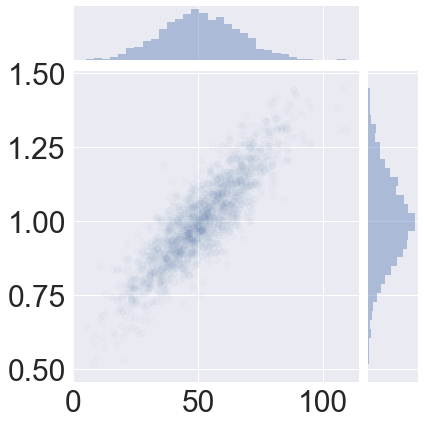

In [54]:
sns.jointplot(betas[:,0],betas[:,1], stat_func=None, joint_kws={'alpha':0.025});

In [55]:
train_predictions = joint_samples.extract("linear_prediction")["linear_prediction"]
test_predictions = joint_samples.extract("y_pred")["y_pred"]

In [56]:
train_errors = compute_errors(train_predictions, train_df.kid_score)

train_mse = np.mean(np.square(train_errors))

In [57]:
test_errors = compute_errors(test_predictions, test_df.kid_score)

test_mse = np.mean(np.square(test_errors))

In [58]:
1-test_mse/test_df.kid_score.var()

0.1688985922838484